Salem Ameen, PhD student at Salford University

### COMPUTER HARDWARE

LASSO Regression

# Import the Libraries

In [1]:
import numpy as np
import pandas
from numpy import *
import time
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn.linear_model import Lasso
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics, grid_search, cross_validation
from IPython.display import set_matplotlib_formats
from bokeh.plotting import figure, show, output_notebook
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from bokeh.layouts import gridplot
output_notebook()
set_matplotlib_formats('png', 'pdf')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

Loading BokehJS ...

# Load data

In the previous file we have not change the data as there is no missing value or add any new parameters so it can be downloaded from the web directly. 

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data'
names = ['vendor', 'Model', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN','CHMAX','PRP','ERP']
feature_names = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN','CHMAX','PRP','ERP']
feature_cols = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN','CHMAX','PRP','ERP']
data = pd.read_csv(url, sep=',', names = names)
data = data.drop('vendor',1)
data = data.drop('Model',1)

from sklearn import preprocessing

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

data, _ = number_encode_features(data)

dataset = data.values
X = dataset[:,0:7]
Y = dataset[:,7]
print 'Number of examples',len(X)

Number of examples 209


In [3]:
# Make developement dataset for genrilization and final testing
from sklearn.cross_validation import train_test_split
# Extracting 20% testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=0)
X = X_train
Y = y_train
new_data      = X_train
new_test_data = X_test
print 'Number of training examples',len(X_train)
print 'Number of validation examples',len(X_test)

Number of training examples 167
Number of validation examples 42


Number of training data is very small so we need to use cross validation instead of spareate another validation data.

From the previous visulization the data has no missing value but has many outlier and some sparisty

# Ranking of the feature's importance to the target

In [4]:
# Using just correlation coefficient even in prevoius file we show them using data frame
for col in feature_cols:
    lm = Lasso(fit_intercept=True)
    lm.fit(data[[col]], data['ERP'])
    print col,'\t', lm.score(data[[col]], data['ERP'])

MYCT 	0.0831720232495
MMIN 	0.671238633036
MMAX 	0.812165716056
CACH 	0.420708210137
CHMIN 	0.372807299482
CHMAX 	0.35064815048
PRP 	0.934067464945
ERP 	0.99999999824


In [5]:
# Randing the important features to the target
model = feature_selection.SelectKBest(score_func=feature_selection.f_regression,k=4)
results = model.fit(data[feature_cols], data['ERP'])
k=0
print 'Feature Name      Score         Pvalue'
for feat in feature_cols:
    print feat,'\t\t',results.scores_[k],'\t',results.pvalues_[k]
    k=k+1


Feature Name      Score         Pvalue
MYCT 		18.7784506906 	2.28953652773e-05
MMIN 		422.636024187 	6.7010130085e-52
MMAX 		895.035239011 	4.20559221576e-77
CACH 		150.332889484 	2.4462451136e-26
CHMIN 		123.042583867 	9.66488661491e-23
CHMAX 		111.779441433 	3.62169179267e-21
PRP 		2932.57297327 	3.42704839853e-124
ERP 		inf 	0.0


# Set the parameters for cross validation

In [6]:
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)

 # Set the parameters for bias-variance dilemma

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Preprocessing the data and save both the model and preprocessed data

In [8]:
# According to the nature of the data spasity and there is outliter RobustScaler class is recomandit 
# but when I tried both of them the result seems is same
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler().fit(X_train)

/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) # use same transform for testing data
X = X_train

/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
# save transformed data
np.save('./data/X_train', X_train)
np.save('./data/y_train', y_train)
np.save('./data/X_test', X_test)
np.save('./data/y_test', y_test)

In [11]:
# save the model scaler to the desk
from sklearn.externals import joblib
joblib.dump(scaler, 'scaler.pkl') 

['scaler.pkl', 'scaler.pkl_01.npy', 'scaler.pkl_02.npy', 'scaler.pkl_03.npy']

In [12]:
# Test the model if it is work
scalerTest = joblib.load('scaler.pkl')
new_data_scaled = scalerTest.transform(new_test_data)
print " =================================================================>>>>> done"
print new_data_scaled

 =================================================================>>>>> done
[[-0.59364305 -0.20866821 -0.31349377  0.98611582 -0.51650809 -0.39068313
  -0.09019932]
 [ 0.43869005 -0.4699337  -0.72397006 -0.63206819 -0.38024134 -0.53321526
  -0.54180082]
 [-0.6318776  -0.04668361 -0.10989753  0.11478597  0.98242613  0.17944539
  -0.26252094]
 [-0.72364055  1.35892472  1.65679241  0.96122068  0.43735914  0.46450965
   1.25272091]
 [-0.55540849  0.31386277  0.01488726 -0.43290708  0.16482565 -0.39068313
  -0.19121544]
 [ 0.43869005 -0.4699337  -0.80606531 -0.63206819 -0.51650809 -0.60448133
  -0.54180082]
 [-0.13482833 -0.20866821  0.34326829 -0.23374597 -0.51650809 -0.4619492
  -0.24469457]
 [ 4.91213348 -0.53054729 -0.88816057 -0.63206819 -0.65277484 -0.67574739
  -0.56556931]
 [-0.28776657 -0.20866821  1.65679241  0.16457625 -0.51650809  1.24843637
   0.2009648 ]
 [-0.63952452  0.31386277  1.00003035  0.16457625  0.43735914  0.17944539
   0.63473992]
 [-0.31453076 -0.4699337  -0.31349

/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# 1. LASSO Regression

The Least Absolute Shrinkage and Selection Operator (or LASSO for short) is a modification of linear regression, like Lasso regression, where the loss function is modified to minimize the complexity of the model measured as the sum absolute value of the coefficient values (also called the l1-norm).

## Validation curve

choosing multiple hyperparameters of an estimator 

In [13]:
from sklearn.linear_model import Lasso,LassoCV
estimator = Lasso()
estimator.get_params().keys()

['normalize',
 'warm_start',
 'selection',
 'fit_intercept',
 'positive',
 'max_iter',
 'precompute',
 'random_state',
 'tol',
 'copy_X',
 'alpha']

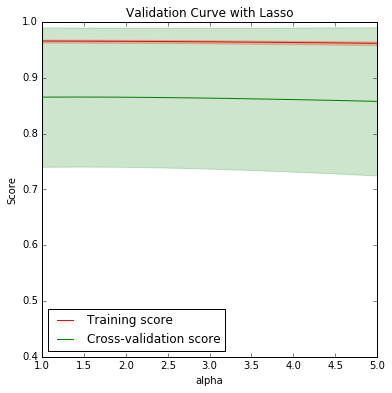

In [14]:
# For parametr alpha
#param_range = np.logspace(-10.0, 10.0)
#param_range = np.logspace(-7, 7, 3)
param_range = np.linspace(1,5.0,10)

train_scores, test_scores = validation_curve(
    Lasso(), X, Y, param_name="alpha", param_range=param_range,
    cv=num_folds,  n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Lasso")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.4, 1.0)
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

It looks alpha between 1 and 2 works well

## Grid search and/or Random search to determine best compination of parameters

In [15]:
# Utility function to report optimal parameters
from operator import itemgetter
def report(grid_scores, n_top=5):
    params = None
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Parameters with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
              score.mean_validation_score, np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if params == None:
            params = score.parameters
    
    return params

# The most common value for the max number of features to look at in each split is sqrt(# of features)
sqrtfeat = np.sqrt(X.shape[1]) 
# Simple grid test (162 combinations)
grid_test1 = { "alpha"      : [1.0, 1.5, 2.0, 2.5],
               "precompute"         : [False, True] }

# Large randomized test using max_depth to control tree size (5000 possible combinations)
random_test1 = { "alpha"          : np.linspace(0,5.0,20),
                 "precompute"         : [False, True] }


forest = Lasso()

print "Hyperparameter optimization using GridSearchCV..."
grid_search = GridSearchCV(forest, grid_test1, n_jobs=-1, cv=num_folds)
grid_search.fit(X, Y)
best_params_from_grid_search = report(grid_search.grid_scores_)
print '+++++++++++++++++++++++++++++++++++++++++++++++'
print "Hyperparameter optimization using RandomizedSearchCV"
grid_search = RandomizedSearchCV(forest, random_test1, n_jobs=-1, cv=num_folds, n_iter=5)
grid_search.fit(X, Y)
best_params_from_rand_search1 = report(grid_search.grid_scores_)

Hyperparameter optimization using GridSearchCV...
Parameters with rank: 1
Mean validation score: 0.8658 (std: 0.1246)
Parameters: {'precompute': False, 'alpha': 1.5}

Parameters with rank: 2
Mean validation score: 0.8658 (std: 0.1246)
Parameters: {'precompute': True, 'alpha': 1.5}

Parameters with rank: 3
Mean validation score: 0.8655 (std: 0.1248)
Parameters: {'precompute': True, 'alpha': 2.0}

Parameters with rank: 4
Mean validation score: 0.8655 (std: 0.1248)
Parameters: {'precompute': False, 'alpha': 2.0}

Parameters with rank: 5
Mean validation score: 0.8655 (std: 0.1249)
Parameters: {'precompute': True, 'alpha': 1.0}

+++++++++++++++++++++++++++++++++++++++++++++++
Hyperparameter optimization using RandomizedSearchCV
Parameters with rank: 1
Mean validation score: 0.8657 (std: 0.1247)
Parameters: {'precompute': False, 'alpha': 1.3157894736842104}

Parameters with rank: 2
Mean validation score: 0.8657 (std: 0.1247)
Parameters: {'precompute': True, 'alpha': 1.8421052631578947}

Para

Best parameters Parameters: {'precompute': False, 'alpha': 0.26315789473684209}


## Learning Curve 

In essence, what we’re doing it training the exact same model with increasingly large fractions of our total training data, and plotting the error of the training and test sets at each step.

/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


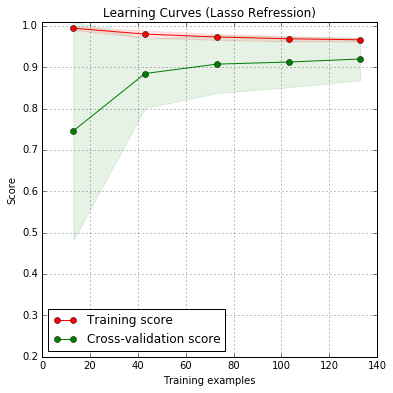

In [16]:
from sklearn.linear_model import Lasso,LassoCV
# 'alpha': 10.0, 'solver': 'lsqr'
model = Lasso(alpha = 0.26315789473684209, precompute = False)
title = "Learning Curves (Lasso Refression)"
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)
plot_learning_curve(model, title, X, Y, ylim=(0.2, 1.01), cv=cv, n_jobs=-1)
plt.show()

In [17]:
# More data from learning curve to show the process of building the model
train_sizes, train_scores, valid_scores = learning_curve(
     model, X, Y, train_sizes=[50, 80, 110], cv=cv, n_jobs=4)

print 'train_sizes = ', train_sizes

print ' training scores'
print ' 50 training sizees'
print train_scores[0].mean(),'±',train_scores[0].std()
print ' 80 training sizees'
print train_scores[1].mean(),'±',train_scores[1].std()
print ' 110 training sizees'
print train_scores[2].mean(),'±',train_scores[2].std()

print '\n validation scores'
print ' 50 validation scores'
print valid_scores[0].mean(),'±',valid_scores[0].std()
print ' 80 validation scores'
print valid_scores[1].mean(),'±',valid_scores[1].std()
print ' 110 validation scores'
print valid_scores[2].mean(),'±',valid_scores[2].std()

train_sizes =  [ 50  80 110]
 training scores
 50 training sizees
0.978430558228 ± 0.00826676048427
 80 training sizees
0.972254278407 ± 0.00754240999457
 110 training sizees
0.968633043895 ± 0.0059413285211

 validation scores
 50 validation scores
0.88999458911 ± 0.0846490031329
 80 validation scores
0.908255896423 ± 0.066410207946
 110 validation scores
0.915566208236 ± 0.0564576172019


## Cross validation

In [18]:
scoring = 'mean_squared_error'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print 'Scoring according to mean_squared_error'
print results
print '\n Mean      Standard deviation'
print("%.2f      %.2f" % (results.mean(), results.std()))
## Fit the model
model.fit(X,Y)
print '\n print intercept and coefficients'
print model.intercept_
print model.coef_
# pair the feature names with the coefficients
print '\n(feature, coefficients)'
print zip(feature_cols, model.coef_)
# Linear qu. of the model



Scoring according to mean_squared_error
[ -729.26407961 -1320.21764337 -1071.67466079 -1121.02871981 -1175.19759988
  -695.61029955  -665.96609863 -1255.74121602 -1127.92972311 -5898.80356606]

 Mean      Standard deviation
-1506.14      1481.51

 print intercept and coefficients
100.94011976
[ 10.11554738  24.3627435   41.77366147  -0.           0.          11.38966587
  98.14325683]

(feature, coefficients)
[('MYCT', 10.115547384269377), ('MMIN', 24.362743500802925), ('MMAX', 41.773661465703753), ('CACH', -0.0), ('CHMIN', 0.0), ('CHMAX', 11.389665873928546), ('PRP', 98.143256831080535)]


To be more precise these valrible is not the input feature as descripe on the dataset, those varibles in scaled virsion on the orginal onces. So, to be more correct I should assign to them another varibles but for easy to unserstand I kept them as they were.

## Coefficients Of Determination {Calculating R^2}

R^2, Close to one is better

In [19]:
predicted = cross_val_predict(model, X, Y, cv=kfold)
r_squared = r2_score(Y, predicted, multioutput='variance_weighted')
print 'R-squared = ',r_squared

R-squared =  0.94391910199


## Residual Plot

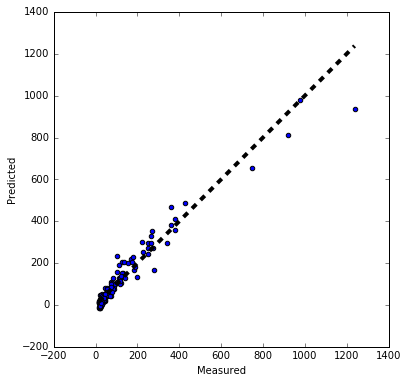

In [20]:
predicted = cross_val_predict(model, X, Y, cv=kfold)
fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [21]:
# Plotining using bokeh
#TOOLS = [BoxSelectTool(), HoverTool()]
#TOOLS = 'hover,box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
p = figure(plot_width=500, plot_height=500, tools=TOOLS)
p.scatter(Y, predicted,x="jjj", marker="o", color="#80B1D3", line_width=3)
p.title.align = "center"
p.xaxis.axis_label = "Measured"
p.xaxis.axis_label_text_color = "#aa6666"
#p.xaxis.axis_label_standoff = 30
p.xaxis.major_tick_line_color = "firebrick"
p.xaxis.major_tick_line_width = 3
p.xaxis.minor_tick_line_color = "orange"
p.yaxis.axis_label = "Predicted"
p.yaxis.axis_label_text_font_style = "italic"
p.yaxis.axis_label_text_color = "#aa6666"
p.background_fill_color = "beige"
p.background_fill_alpha = 0.5
#p.line([Y.min(), Y.max()], [Y.min(), Y.max()], line_dash="4 4", line_width=2, color='red')

# create a new plot with the toolbar below
# line_dash="4 4", line_width=2, color='red'
p.line([Y.min(), Y.max()], [Y.min(), Y.max()], line_dash="4 4", line_width=2, line_color="black")
show(p)

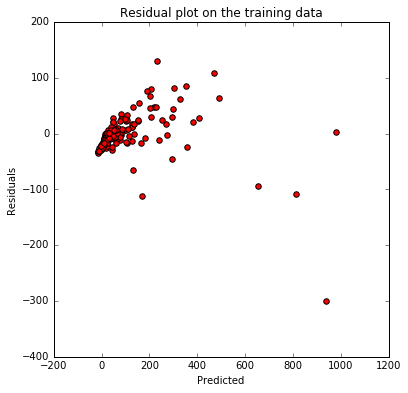

In [22]:
plt.scatter(predicted, (predicted - Y), c='r', s=30)
plt.title("Residual plot on the training data")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

In [23]:
# Plotining using bokeh
#TOOLS = 'hover,box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
p = figure(plot_width=500, plot_height=500, title="Residual plot on the training data", tools=TOOLS)
p.scatter(predicted, (predicted - Y),x="jjj", marker="o", color="#80B1D3", line_width=3)
p.title.align = "center"
p.xaxis.axis_label = "Predicted"
p.xaxis.axis_label_text_color = "#aa6666"
#p.xaxis.axis_label_standoff = 30
p.xaxis.major_tick_line_color = "firebrick"
p.xaxis.major_tick_line_width = 3
p.xaxis.minor_tick_line_color = "orange"
p.yaxis.axis_label = "Residuals"
p.yaxis.axis_label_text_font_style = "italic"
p.yaxis.axis_label_text_color = "#aa6666"
p.background_fill_color = "beige"
p.background_fill_alpha = 0.5
#p.line([2,38], [0, 0], line_dash="4 4", line_width=2, color='red')
show(p)

## Pipeline

The best to deliver the model by pipeline the operation then at deployment can be done in one model.

  I used two ways to check the pipeline so any one can be fine

In [24]:
# Use Pipeline
# ANOVA 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
anova_filter = SelectKBest(f_regression, k=7)
LR = Lasso(alpha = 0.26315789473684209, precompute = False)
anova_LinReg = Pipeline([('scaler_Input',scaler), ('anova', anova_filter), ('LinReg', LR)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
anova_LinReg.set_params(anova__k=7).fit(new_data, Y)
prediction = anova_LinReg.predict(new_data)
print anova_LinReg.score(new_data, Y)                        
# getting the selected features chosen by anova_filter
results = cross_validation.cross_val_score(anova_LinReg, new_data, Y, cv=kfold, scoring=scoring)
print 'Scoring according to mean_squared_error'
print results
print '\n Mean      Standard deviation'
print("%.2f      %.2f" % (results.mean(), results.std()))
print anova_LinReg.named_steps['anova'].get_support()
r_squared = r2_score(Y, prediction, multioutput='variance_weighted')
print 'R-squared = ',r_squared

0.965473603767
Scoring according to mean_squared_error
[ -729.44390621 -1320.7022897  -1071.13468452 -1120.93855143 -1178.13968251
  -695.36601149  -665.80648944 -1256.44094215 -1124.0766566  -5864.92233594]

 Mean      Standard deviation
-1502.70      1471.51
[ True  True  True  True  True  True  True]
R-squared =  0.965473603767


/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with i

In [25]:
# Using make_pipeline
from sklearn.pipeline import make_pipeline

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=7)
anova_Lasso = make_pipeline(scaler, anova_filter, LR)
anova_Lasso.fit(new_data, Y)
prediction = anova_Lasso.predict(new_data)
r_squared = r2_score(Y, prediction, multioutput='variance_weighted')
print 'R-squared = ',r_squared

R-squared =  0.965473603767


/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Save the Pipeline model for developement

In [26]:
# save the model scaler to the desk
from sklearn.externals import joblib
joblib.dump(anova_Lasso, 'anova_Lasso.pkl') 

['anova_Lasso.pkl',
 'anova_Lasso.pkl_01.npy',
 'anova_Lasso.pkl_02.npy',
 'anova_Lasso.pkl_03.npy',
 'anova_Lasso.pkl_04.npy',
 'anova_Lasso.pkl_05.npy',
 'anova_Lasso.pkl_06.npy',
 'anova_Lasso.pkl_07.npy']

In [27]:
# Test the model if it is work
anova_LassoTest = joblib.load('anova_Lasso.pkl')
NewPred = anova_LassoTest.predict(new_data)
print " =================================================================>>>>> done"
r_squared = r2_score(Y, NewPred, multioutput='variance_weighted')
print 'R-squared = ',r_squared

 =================================================================>>>>> done
R-squared =  0.965473603767


/home/salm/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
# test on single data point, randomly choose point number 55
print 'Point of training data before normalization\n',new_data[55]
print '\nThe read target of the data = ', Y[55]
NewPred = anova_LassoTest.predict([new_data[55]])
print '\nThe Predicted target of the data = ', NewPred

Point of training data before normalization
[   50  2000 32000    24     6    26   114]

The read target of the data =  182

The Predicted target of the data =  [ 165.50790072]


## Conclusion 